Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4953 images belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


Epoch 1/10
5/5 [==============================] - 86s 15s/step - loss: 1.4200 - accuracy: 0.1875 - val_loss: 1.3745 - val_accuracy: 0.3000
Epoch 2/10
5/5 [==============================] - 38s 8s/step - loss: 1.3651 - accuracy: 0.3500 - val_loss: 1.3515 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 43s 9s/step - loss: 1.3415 - accuracy: 0.4313 - val_loss: 1.3370 - val_accuracy: 0.3000
Epoch 4/10
5/5 [==============================] - 42s 8s/step - loss: 1.3310 - accuracy: 0.3812 - val_loss: 1.3295 - val_accuracy: 0.3000
Epoch 5/10
5/5 [==============================] - 40s 8s/step - loss: 1.3207 - accuracy: 0.3375 - val_loss: 1.3130 - val_accuracy: 0.3750
Epoch 6/10
5/5 [==============================] - 38s 8s/step - loss: 1.3030 - accuracy: 0.3812 - val_loss: 1.2986 - val_accuracy: 0.3000
Epoch 7/10
5/5 [==============================] - 42s 9s/step - loss: 1.2825 - accuracy: 0.4062 - val_loss: 1.2877 - val_accuracy: 0.3500
Epoch 8/10
5/5 [=================

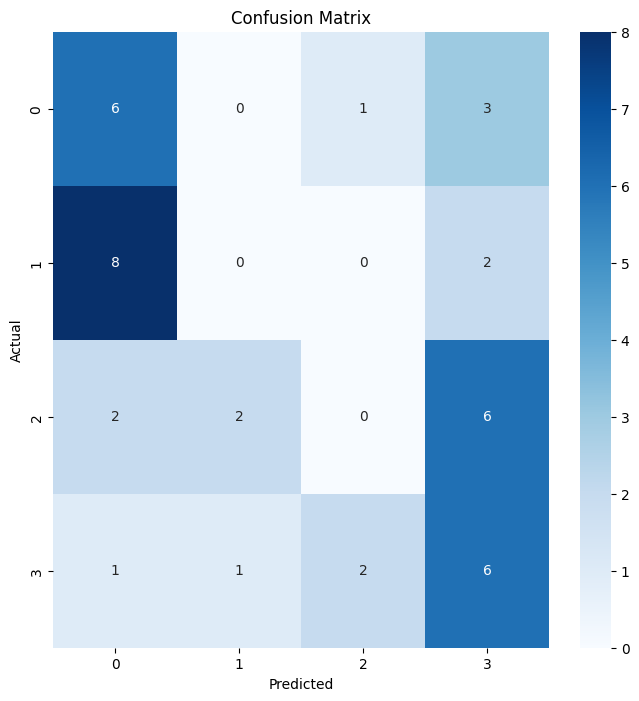

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

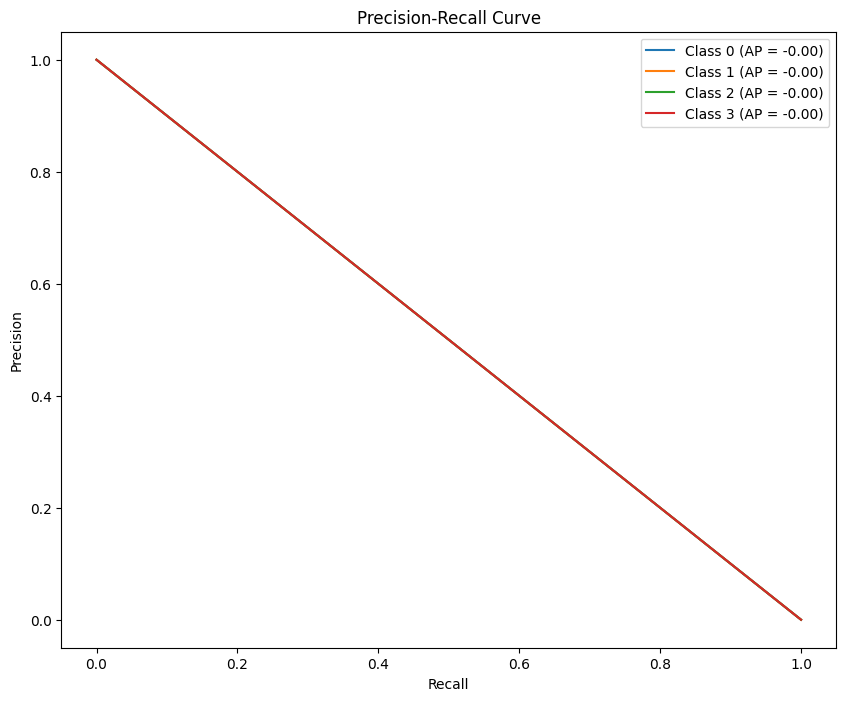

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import random
import pandas as pd

# Mount Google Drive if your dataset is stored there
# from google.colab import drive
# drive.mount('/content/drive')

# Data Preprocessing with a specified number of images per class
data_dir = '/content/drive/MyDrive/Dataset'
img_size = (224, 224)
batch_size = 32
validation_split = 0.2
n_images_per_class = 50  # Specifying the number of images per class

datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory without shuffle
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Randomly selecting 'n_images_per_class' from each class
selected_images = []
for class_folder in all_images_generator.class_indices.keys():
    class_folder_path = os.path.join(data_dir, class_folder)
    all_images = [f"{class_folder}/{img}" for img in os.listdir(class_folder_path)]
    selected_images.extend(random.sample(all_images, n_images_per_class))

# Create a DataFrame with the selected images
df = pd.DataFrame({'filename': selected_images, 'class': [img.split('/')[0] for img in selected_images]})

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df, test_size=validation_split, stratify=df['class'])

# Now, create generators using the DataFrames
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Building the ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(len(all_images_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluation on the validation set
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualization 2: Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(all_images_generator.class_indices)):
    binary_y_true = np.zeros_like(y_true)
    binary_y_true[y_true == i] = 1
    precision[i], recall[i], _ = precision_recall_curve(binary_y_true, y_pred[:, i])
    average_precision[i] = average_precision_score(binary_y_true, y_pred[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(all_images_generator.class_indices)):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

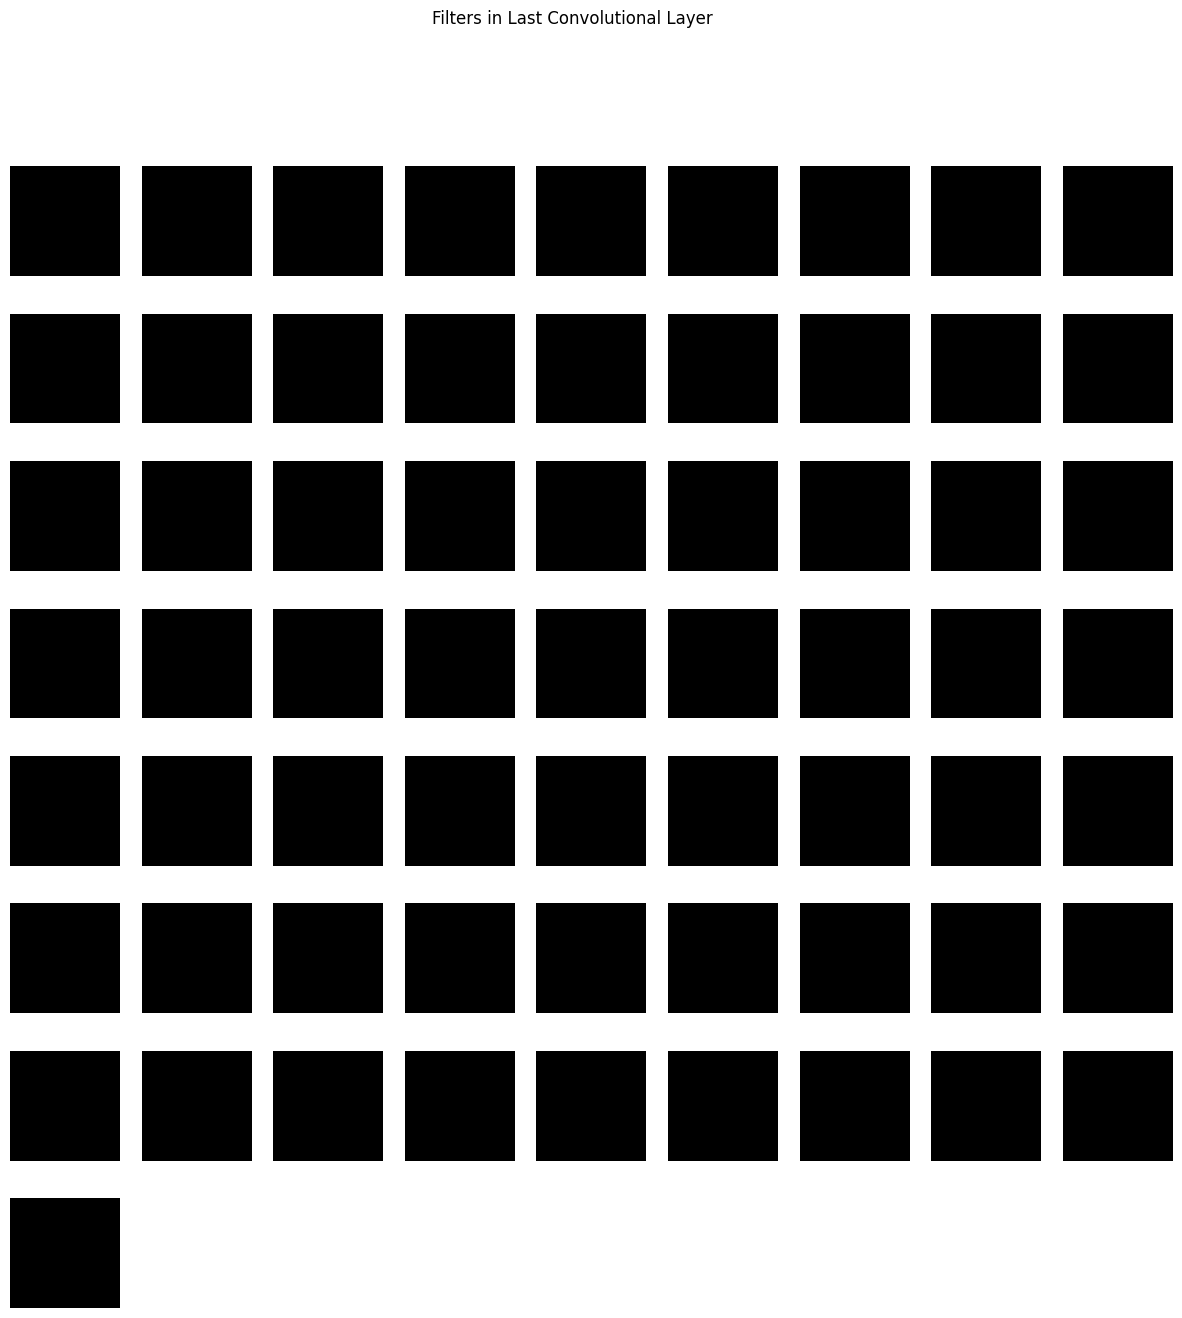

2/2 [==============================] - 7s 2s/step
Inference Time: 0:00:07.659909


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Size: 90.43 MB
Model Size: 90.43 MB
2/2 [==============================] - 7s 1s/step
AUC-ROC: 0.67
2/2 [==============================] - 8s 2s/step
----------------------------------
Scalability Metrics:
Batch Size 16: 0:00:08.567937
2/2 [==============================] - 7s 1s/step
----------------------------------
Scalability Metrics:
Batch Size 32: 0:00:10.925905
2/2 [==============================] - 11s 1s/step
----------------------------------
Scalability Metrics:
Batch Size 64: 0:00:20.979886
--------------------------------------
Accuracies:
Training Accuracy: 0.4625
Validation Accuracy: 0.3000
Training vs Validation Accuracy: 0.4625000059604645 vs 0.30000001192092896


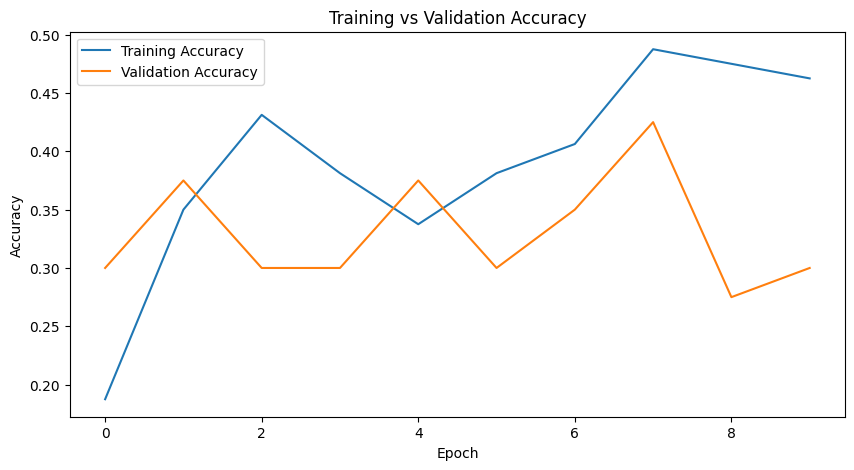

In [15]:
import tensorflow as tf
conv_layer = None
for layer in model.layers[0].layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer = layer

if conv_layer is not None:
    filters = conv_layer.get_weights()[0]
    num_filters = min(filters.shape[3], 64)
    rows = min(num_filters // 8, 8)
    cols = (num_filters // rows) + 1
    # Display the filters
    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(filters[:, :, 0, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Filters in Last Convolutional Layer')
    plt.show()
else:
    print("No Convolutional Layer found in the model.")
# Additional Metrics Calculation
start_time = datetime.now()

# Performance Metrics
inference_start = datetime.now()
model.predict(val_generator)
inference_time = datetime.now() - inference_start
print(f'Inference Time: {inference_time}')

# Efficiency Metrics
model.save('model.h5')
model_path = 'model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

model.save('/content/drive/MyDrive/model.h5')

# Get the size of the saved model
model_path = '/content/drive/MyDrive/model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

# Quality Metrics
y_pred_prob = model.predict(val_generator)
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')

print(f'AUC-ROC: {roc_auc:.2f}')

# Scalability Metrics
batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
    start_time = datetime.now()
    model.predict(val_generator, batch_size=batch_size)  # Replace with your actual prediction function
    elapsed_time = datetime.now() - start_time
    print("----------------------------------")
    print("Scalability Metrics:")
    print(f'Batch Size {batch_size}: {elapsed_time}')

# Accuracy Calculation
accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("--------------------------------------")
print("Accuracies:")
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Training vs Validation Accuracy: {accuracy} vs {val_accuracy}')

# Training vs Validation Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4953 images belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
Found 100 validated image filenames belonging to 4 classes.


Epoch 1/10
13/13 [==============================] - 194s 15s/step - loss: 1.4697 - accuracy: 0.2925 - val_loss: 1.3774 - val_accuracy: 0.2700
Epoch 2/10
13/13 [==============================] - 135s 11s/step - loss: 1.3245 - accuracy: 0.3700 - val_loss: 1.3249 - val_accuracy: 0.3800
Epoch 3/10
13/13 [==============================] - 102s 8s/step - loss: 1.2841 - accuracy: 0.4200 - val_loss: 1.2843 - val_accuracy: 0.4000
Epoch 4/10
13/13 [==============================] - 97s 8s/step - loss: 1.2557 - accuracy: 0.4275 - val_loss: 1.2747 - val_accuracy: 0.3800
Epoch 5/10
13/13 [==============================] - 98s 8s/step - loss: 1.2424 - accuracy: 0.4000 - val_loss: 1.2600 - val_accuracy: 0.3900
Epoch 6/10
13/13 [==============================] - 96s 7s/step - loss: 1.2255 - accuracy: 0.4675 - val_loss: 1.2544 - val_accuracy: 0.3800
Epoch 7/10
13/13 [==============================] - 98s 8s/step - loss: 1.2116 - accuracy: 0.4425 - val_loss: 1.2461 - val_accuracy: 0.4100
Epoch 8/10
13/1

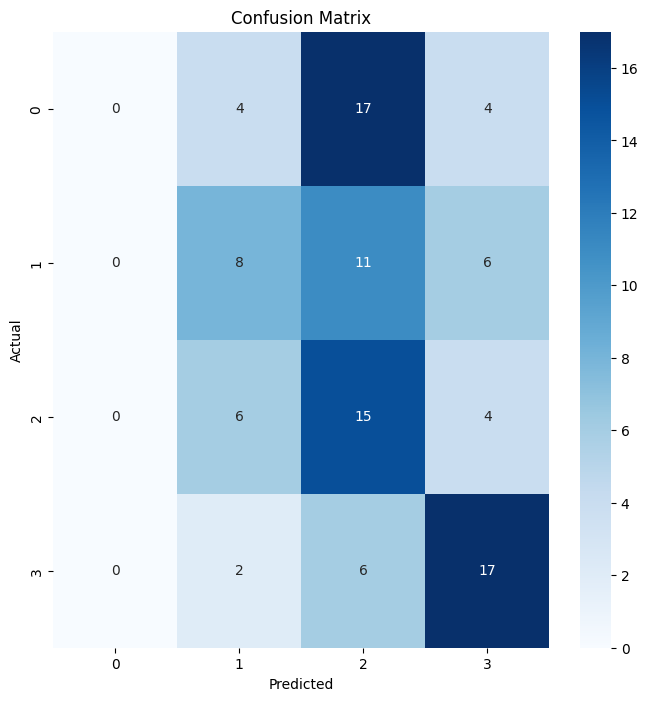

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

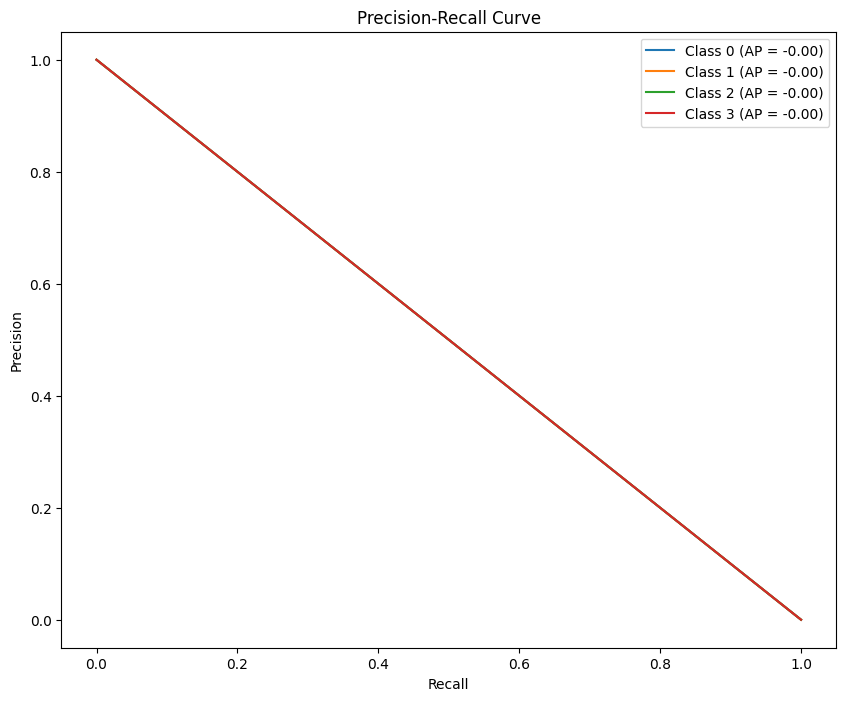

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import random
import pandas as pd

# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing with a specified number of images per class
data_dir = '/content/drive/MyDrive/Dataset'
img_size = (224, 224)
batch_size = 32
validation_split = 0.2
n_images_per_class = 125  # Specifying the number of images per class

datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory without shuffle
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

# Randomly select 'n_images_per_class' from each class
selected_images = []
for class_folder in all_images_generator.class_indices.keys():
    class_folder_path = os.path.join(data_dir, class_folder)
    all_images = [f"{class_folder}/{img}" for img in os.listdir(class_folder_path)]
    selected_images.extend(random.sample(all_images, n_images_per_class))

# Create a DataFrame with the selected images
df = pd.DataFrame({'filename': selected_images, 'class': [img.split('/')[0] for img in selected_images]})

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df, test_size=validation_split, stratify=df['class'])

train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Build the ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(len(all_images_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluation on the validation set
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualization 2: Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(all_images_generator.class_indices)):
    binary_y_true = np.zeros_like(y_true)
    binary_y_true[y_true == i] = 1
    precision[i], recall[i], _ = precision_recall_curve(binary_y_true, y_pred[:, i])
    average_precision[i] = average_precision_score(binary_y_true, y_pred[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(all_images_generator.class_indices)):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

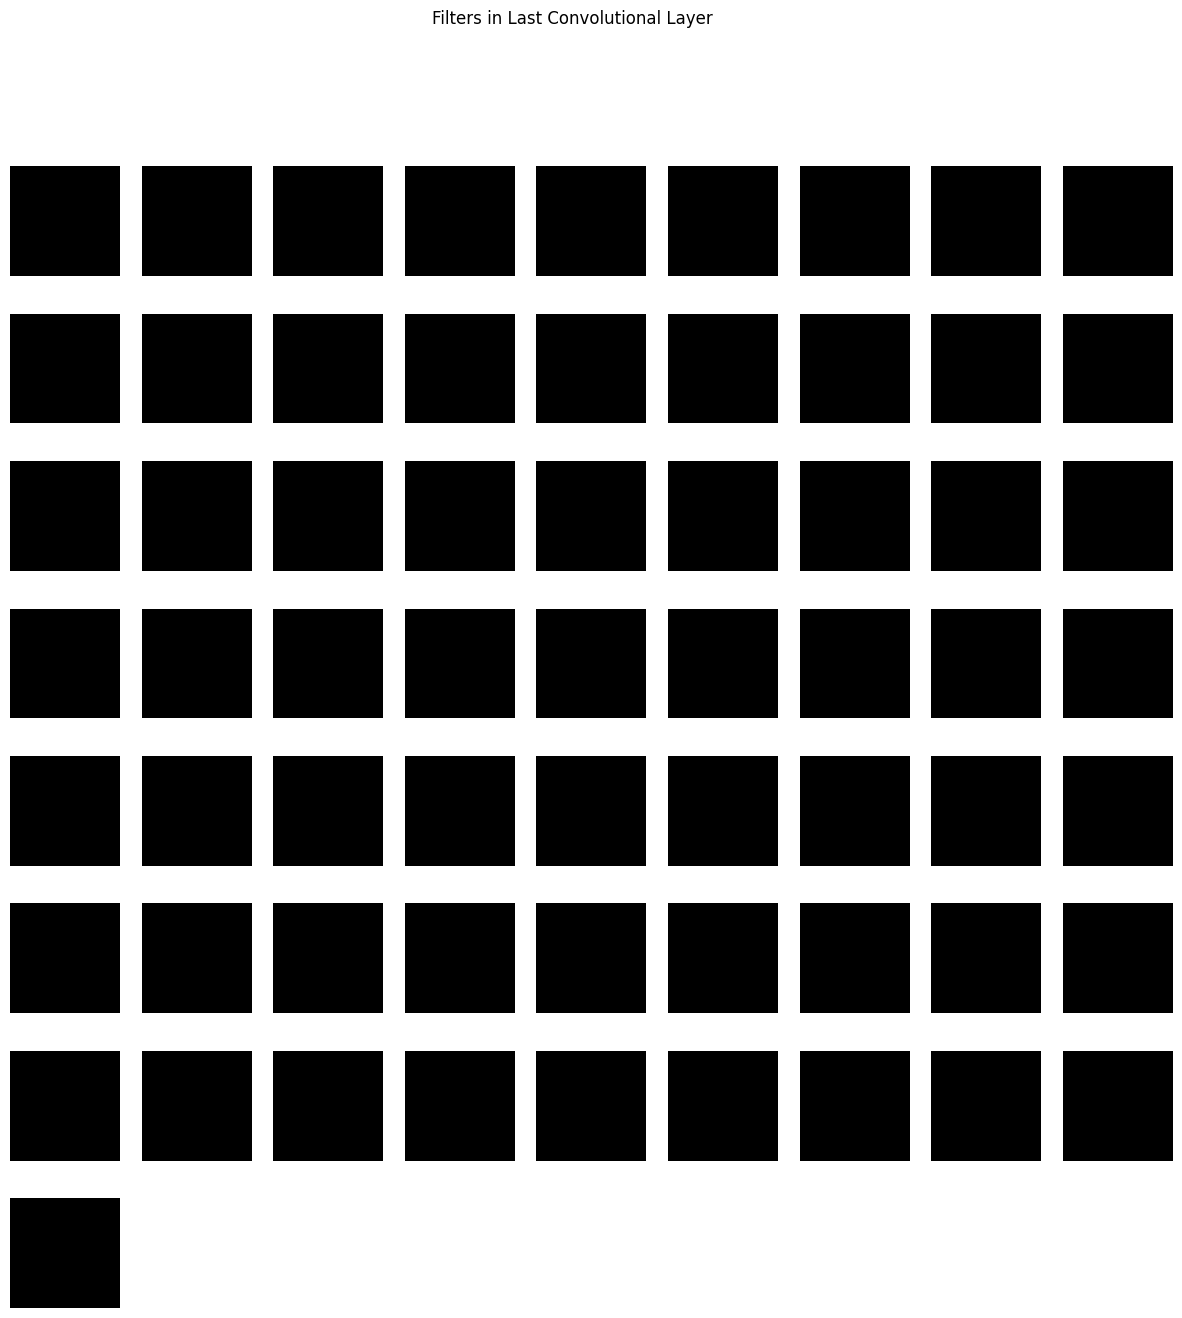

4/4 [==============================] - 19s 4s/step
Inference Time: 0:00:20.962743


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Size: 90.43 MB
Model Size: 90.43 MB
4/4 [==============================] - 19s 4s/step
AUC-ROC: 0.72
4/4 [==============================] - 19s 3s/step
----------------------------------
Scalability Metrics:
Batch Size 16: 0:00:20.953739
4/4 [==============================] - 20s 4s/step
----------------------------------
Scalability Metrics:
Batch Size 32: 0:00:21.100934
4/4 [==============================] - 19s 4s/step
----------------------------------
Scalability Metrics:
Batch Size 64: 0:00:19.895925
----------------------------------
Accuracies:
Training Accuracy: 0.4500
Validation Accuracy: 0.4000
Training vs Validation Accuracy: 0.44999998807907104 vs 0.4000000059604645


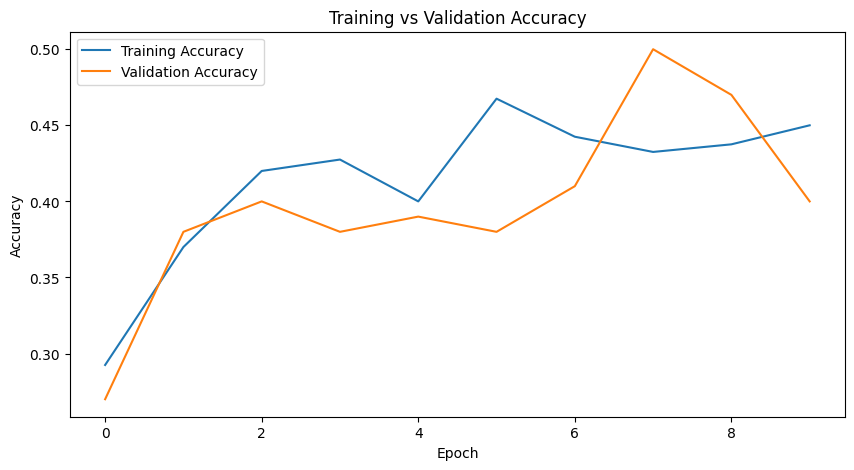

In [17]:
import tensorflow as tf
conv_layer = None
for layer in model.layers[0].layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer = layer

if conv_layer is not None:
    filters = conv_layer.get_weights()[0]
    num_filters = min(filters.shape[3], 64)
    rows = min(num_filters // 8, 8)
    cols = (num_filters // rows) + 1
    # Display the filters
    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(filters[:, :, 0, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Filters in Last Convolutional Layer')
    plt.show()
else:
    print("No Convolutional Layer found in the model.")
# Additional Metrics Calculation
start_time = datetime.now()

# Performance Metrics
inference_start = datetime.now()
model.predict(val_generator)
inference_time = datetime.now() - inference_start
print(f'Inference Time: {inference_time}')

# Efficiency Metrics
model.save('model.h5')
model_path = 'model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

model.save('/content/drive/MyDrive/model.h5')

# Get the size of the saved model
model_path = '/content/drive/MyDrive/model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

# Quality Metrics
y_pred_prob = model.predict(val_generator)
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')

print(f'AUC-ROC: {roc_auc:.2f}')

# Scalability Metrics
batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
    start_time = datetime.now()
    model.predict(val_generator, batch_size=batch_size)  # Replace with your actual prediction function
    elapsed_time = datetime.now() - start_time
    print("----------------------------------")
    print("Scalability Metrics:")
    print(f'Batch Size {batch_size}: {elapsed_time}')

# Accuracy Calculation
accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("----------------------------------")
print("Accuracies:")
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Training vs Validation Accuracy: {accuracy} vs {val_accuracy}')

# Training vs Validation Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4953 images belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.


Epoch 1/10
50/50 [==============================] - 687s 14s/step - loss: 1.3296 - accuracy: 0.3606 - val_loss: 1.2692 - val_accuracy: 0.4450
Epoch 2/10
50/50 [==============================] - 394s 8s/step - loss: 1.2446 - accuracy: 0.4263 - val_loss: 1.2247 - val_accuracy: 0.4525
Epoch 3/10
50/50 [==============================] - 395s 8s/step - loss: 1.2109 - accuracy: 0.4425 - val_loss: 1.2471 - val_accuracy: 0.4000
Epoch 4/10
50/50 [==============================] - 401s 8s/step - loss: 1.1890 - accuracy: 0.4437 - val_loss: 1.1859 - val_accuracy: 0.4375
Epoch 5/10
50/50 [==============================] - 391s 8s/step - loss: 1.1658 - accuracy: 0.4869 - val_loss: 1.1581 - val_accuracy: 0.5175
Epoch 6/10
50/50 [==============================] - 380s 8s/step - loss: 1.1546 - accuracy: 0.4938 - val_loss: 1.1556 - val_accuracy: 0.4425
Epoch 7/10
50/50 [==============================] - 382s 8s/step - loss: 1.1387 - accuracy: 0.4956 - val_loss: 1.1334 - val_accuracy: 0.5275
Epoch 8/10
5

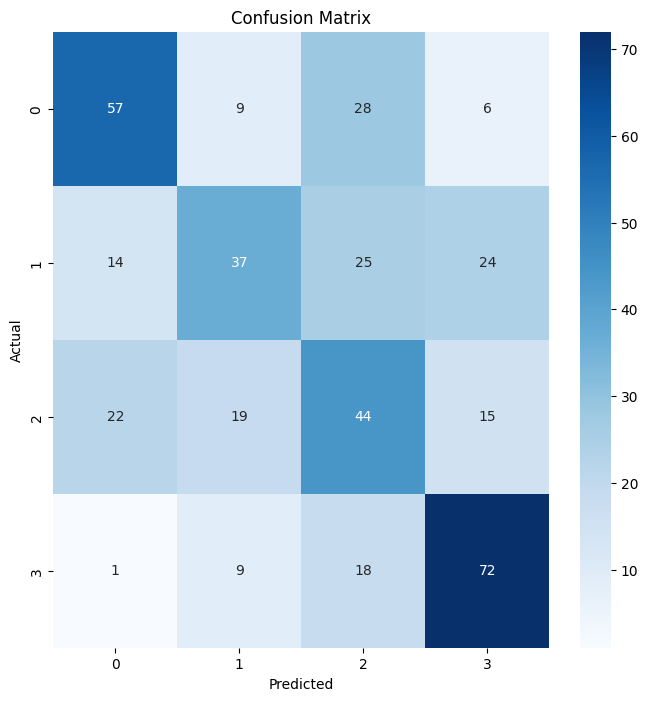

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

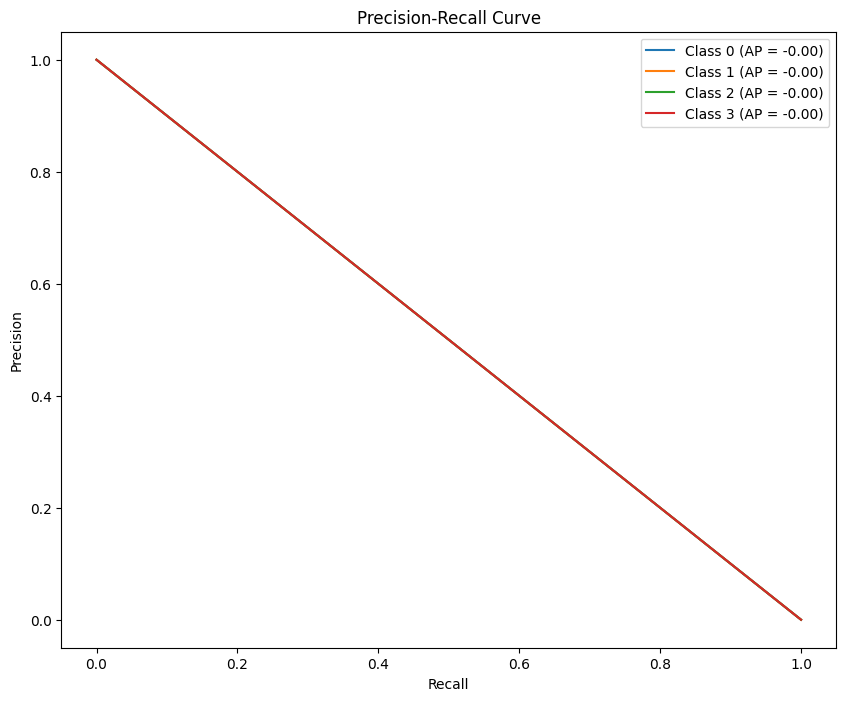

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from datetime import datetime
import random
import pandas as pd

# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

# Data Preprocessing with a specified number of images per class
data_dir = '/content/drive/MyDrive/Dataset'
img_size = (224, 224)
batch_size = 32
validation_split = 0.2
n_images_per_class = 500  # Specify the number of images per class

datagen = ImageDataGenerator(
    rescale=1./255
)

# Flow from directory without shuffle
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Randomly select 'n_images_per_class' from each class
selected_images = []
for class_folder in all_images_generator.class_indices.keys():
    class_folder_path = os.path.join(data_dir, class_folder)
    all_images = [f"{class_folder}/{img}" for img in os.listdir(class_folder_path)]
    selected_images.extend(random.sample(all_images, n_images_per_class))

# Create a DataFrame with the selected images
df = pd.DataFrame({'filename': selected_images, 'class': [img.split('/')[0] for img in selected_images]})

# Split the DataFrame into training and validation sets
train_df, val_df = train_test_split(df, test_size=validation_split, stratify=df['class'])

train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='filename',
    y_col='class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Build the ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(len(all_images_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluation on the validation set
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualization 2: Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(all_images_generator.class_indices)):
    binary_y_true = np.zeros_like(y_true)
    binary_y_true[y_true == i] = 1
    precision[i], recall[i], _ = precision_recall_curve(binary_y_true, y_pred[:, i])
    average_precision[i] = average_precision_score(binary_y_true, y_pred[:, i])

plt.figure(figsize=(10, 8))
for i in range(len(all_images_generator.class_indices)):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

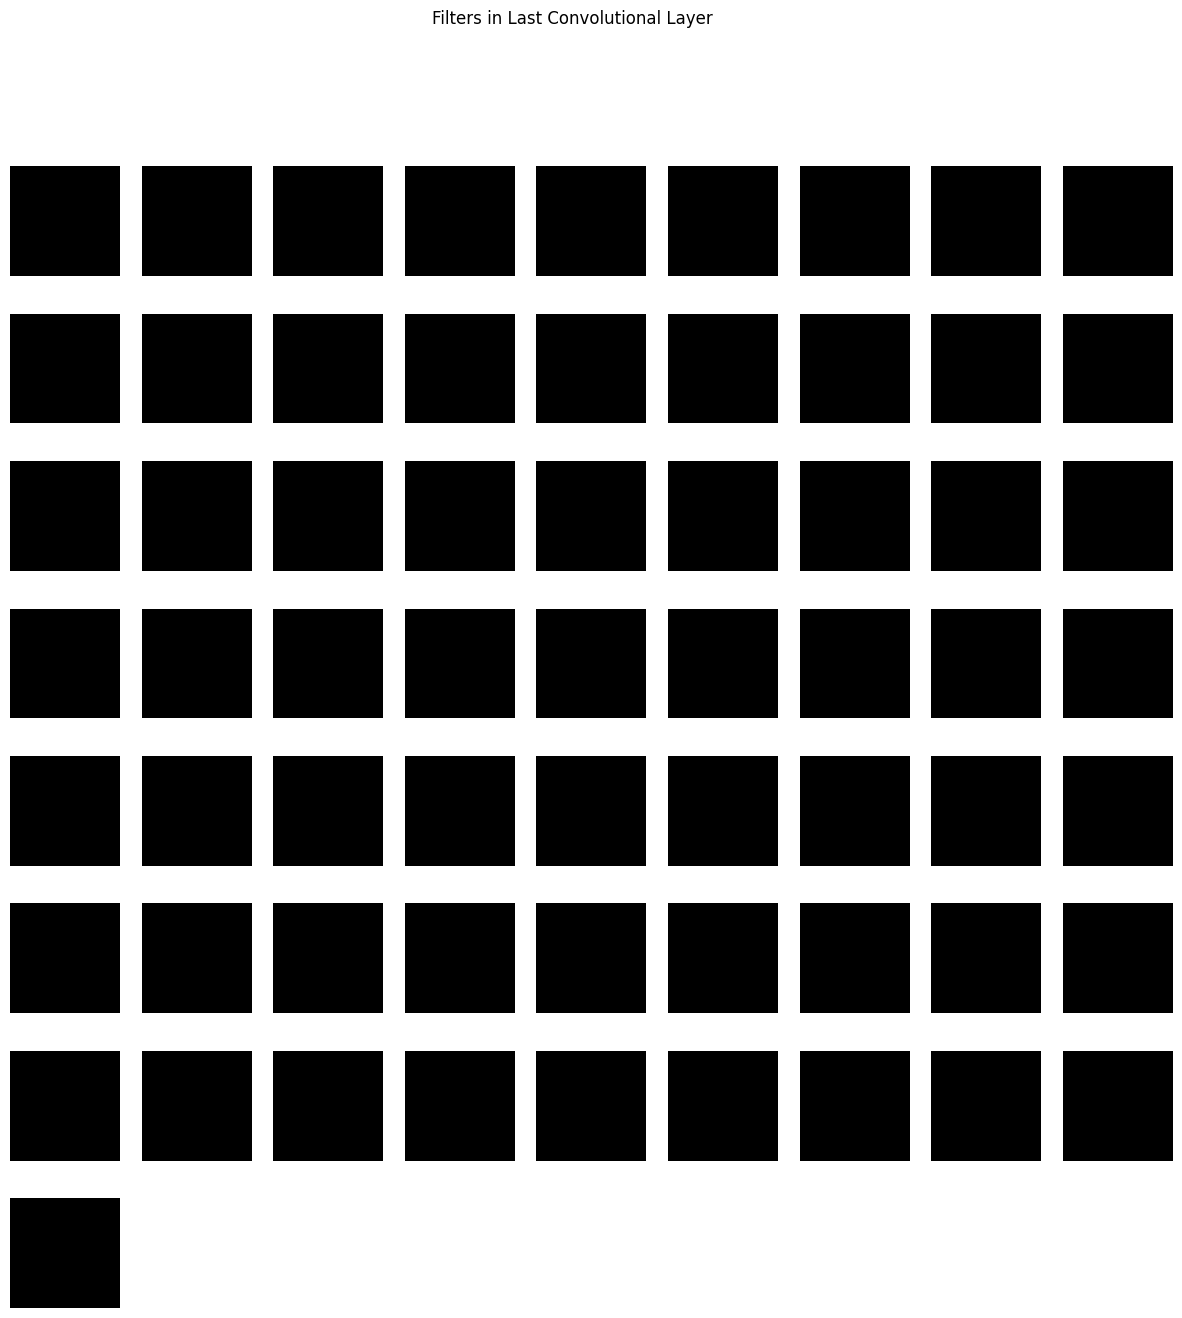

13/13 [==============================] - 91s 7s/step
Inference Time: 0:01:31.975689


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Size: 90.43 MB
Model Size: 90.43 MB
13/13 [==============================] - 79s 6s/step
AUC-ROC: 0.79
13/13 [==============================] - 77s 6s/step
----------------------------------
Scalability Metrics:
Batch Size 16: 0:01:18.177558
13/13 [==============================] - 78s 6s/step
----------------------------------
Scalability Metrics:
Batch Size 32: 0:01:18.849625
13/13 [==============================] - 78s 6s/step
----------------------------------
Scalability Metrics:
Batch Size 64: 0:01:22.637644
----------------------------------
Accuracies:
Training Accuracy: 0.5400
Validation Accuracy: 0.5250
Training vs Validation Accuracy: 0.5400000214576721 vs 0.5249999761581421


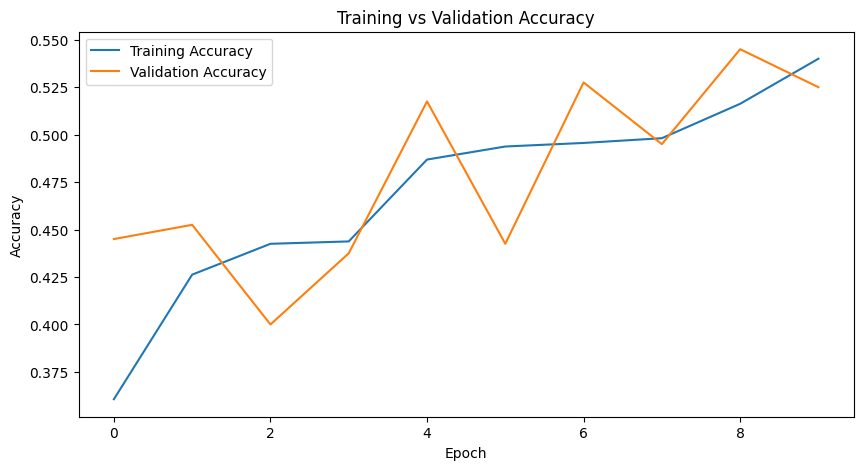

In [19]:
import tensorflow as tf
conv_layer = None
for layer in model.layers[0].layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_layer = layer

if conv_layer is not None:
    filters = conv_layer.get_weights()[0]
    num_filters = min(filters.shape[3], 64)
    rows = min(num_filters // 8, 8)
    cols = (num_filters // rows) + 1
    # Display the filters
    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(filters[:, :, 0, i], cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Filters in Last Convolutional Layer')
    plt.show()
else:
    print("No Convolutional Layer found in the model.")
# Additional Metrics Calculation
start_time = datetime.now()

# Performance Metrics
inference_start = datetime.now()
model.predict(val_generator)
inference_time = datetime.now() - inference_start
print(f'Inference Time: {inference_time}')

# Efficiency Metrics
model.save('model.h5')
model_path = 'model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

model.save('/content/drive/MyDrive/model.h5')

# Get the size of the saved model
model_path = '/content/drive/MyDrive/model.h5'
model_size = os.path.getsize(model_path)
print(f'Model Size: {model_size / (1024 * 1024):.2f} MB')

# Quality Metrics
y_pred_prob = model.predict(val_generator)
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(f'AUC-ROC: {roc_auc:.2f}')

# Scalability Metrics
batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
    start_time = datetime.now()
    model.predict(val_generator, batch_size=batch_size)
    elapsed_time = datetime.now() - start_time
    print("----------------------------------")
    print("Scalability Metrics:")
    print(f'Batch Size {batch_size}: {elapsed_time}')

# Accuracy Calculation
accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print("----------------------------------")
print("Accuracies:")
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Training vs Validation Accuracy: {accuracy} vs {val_accuracy}')

# Training vs Validation Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ResNet:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import numpy as np

# Set the path to your dataset
data_dir = '/content/drive/MyDrive/Dataset'

# Load and preprocess the data
def load_and_preprocess_data(data_dir, img_size=(331, 331)):
    data = []
    labels = []

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)

            data.append(img_array)
            labels.append(label)

    return np.array(data), np.array(labels)

# Load the data
X, y = load_and_preprocess_data(data_dir)

# Convert labels to one-hot encoding
label_to_index = {label: i for i, label in enumerate(np.unique(y))}
index_to_label = {i: label for label, i in label_to_index.items()}
y = np.vectorize(label_to_index.get)(y)
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained NASNetLarge model
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(label_to_index), activation='softmax')(x)

model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MobileNet:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset
data_dir = '/content/drive/MyDrive/Dataset'

# Load and preprocess the data
def load_and_preprocess_data(data_dir, img_size=(224, 224)):
    data = []
    labels = []

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = image.load_img(img_path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)

            data.append(img_array)
            labels.append(label)

    return np.array(data), np.array(labels)

# Load the data
X, y = load_and_preprocess_data(data_dir)

# Convert labels to one-hot encoding
label_to_index = {label: i for i, label in enumerate(np.unique(y))}
index_to_label = {i: label for label, i in label_to_index.items()}
y = np.vectorize(label_to_index.get)(y)
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(label_to_index), activation='softmax')(x)

model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy}")

Mounted at /content/drive
9406464/9406464 [==============================] - 0s 0us/step
